In [10]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data

column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']
data = pd.read_csv("twitter_training.csv",
                    sep=',',names=column_names)

# Display the first few rows of the dataframe
data.head()


,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, float):
        return ""
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#', '', text)        # remove hashtags
    text = re.sub(r'\d+', '', text)      # remove numbers
    text = text.lower()                  # convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # remove stopwords
    return text

data['cleaned_text'] = data['Tweet_content'].astype(str).apply(clean_text)

# Display the first few rows of the cleaned dataframe
data.head()


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


,Tweet_ID,Entity,Sentiment,Tweet_content,cleaned_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder


In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define max number of words and max sequence length
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Prepare labels (assuming Sentiment is categorical with values like 'Positive', 'Negative', 'Neutral')
label_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}  # Adjust according to your needs
data['label'] = data['Sentiment'].map(label_mapping)

# Drop any rows with NaN labels
data = data.dropna(subset=['label'])

# Update sequences and labels after dropping NaNs
padded_sequences = padded_sequences[data.index]
labels = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Display shapes of training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(49353, 100) (12339, 100) (49353,) (12339,)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 130s 103ms/step - accuracy: 0.3879 - loss: -2.1697 - val_accuracy: 0.5281 - val_loss: -11.9012
Epoch 2/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 127s 103ms/step - accuracy: 0.5231 - loss: -18.5642 - val_accuracy: 0.5403 - val_loss: -27.5504
Epoch 3/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 125s 101ms/step - accuracy: 0.5511 - loss: -36.2912 - val_accuracy: 0.5515 - val_loss: -42.1010
Epoch 4/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 124s 100ms/step - accuracy: 0.5580 - loss: -56.3098 - val_accuracy: 0.5590 - val_loss: -58.3335
Epoch 5/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 121s 98ms/step - accuracy: 0.5700 - loss: -75.8221 - val_accuracy: 0.5659 - val_loss: -76.6088
Epoch 6/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 126s 102ms/step - accuracy: 0.5848 - loss: -95.7957 - val_accuracy: 0.5591 - val_loss: -91.3879
Epoch 7/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 127s 103ms/step - accuracy: 0.5846 - loss: -116.2079 - val_accuracy: 0.5676 - val_loss: -109.0765
Epoch 8/10
1234/1234 ━━━━━━━━━━━━━

386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5669 - loss: -165.7282
Test Accuracy: 56.80%


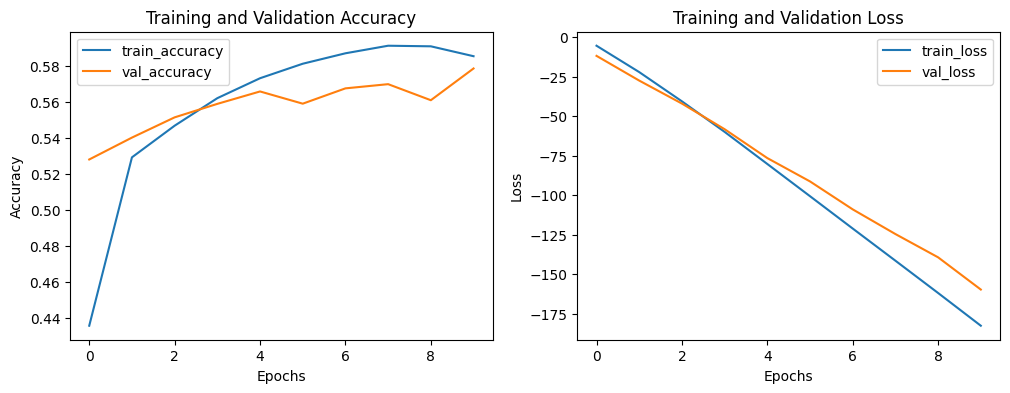

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training and validation accuracy/loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Build the RNN model with a simple RNN layer
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(SimpleRNN(32)))
model.add(Dense(3, activation='softmax'))  # Adjust output layer for 3 classes

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.5231 - loss: 0.9458 - val_accuracy: 0.7702 - val_loss: 0.5699
Epoch 2/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8484 - loss: 0.3892 - val_accuracy: 0.7992 - val_loss: 0.5008
Epoch 3/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.8955 - loss: 0.2669 - val_accuracy: 0.8216 - val_loss: 0.4844
Epoch 4/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.9229 - loss: 0.1894 - val_accuracy: 0.7992 - val_loss: 0.5836
Epoch 5/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9222 - loss: 0.1863 - val_accuracy: 0.7894 - val_loss: 0.6020
Epoch 6/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - accuracy: 0.9228 - loss: 0.1862 - val_accuracy: 0.8264 - val_loss: 0.5585
Epoch 7/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.9413 - loss: 0.1327 - val_accuracy: 0.7486 - val_loss: 0.7595
Epoch 8/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 182s 148ms/step - accuracy: 0.8929